
# CS2 Knowledge Graph Embeddings — Complete Pipeline

Этот ноутбук содержит полный пайплайн для работы с графом знаний CS2 на основе датасета `my_data.csv`. Мы последовательно загрузим данные, сформируем тройки, обучим модель векторных представлений (KGE), визуализируем эмбеддинги, выполним кластеризацию, классификацию и простое предсказание недостающих ссылок.



## Установка зависимостей

Для корректной работы понадобится установить несколько библиотек. Если вы запускаете ноутбук на Google Colab, эти команды уже будут установлены. В противном случае выполните следующий код:


In [ ]:

# !pip install pykeen pandas rdflib matplotlib scikit-learn umap-learn xgboost -q



## Импорт библиотек

Импортируем необходимые библиотеки для работы с данными, графами знаний, машинным обучением и визуализацией.


In [14]:

import pandas as pd
import numpy as np
from rdflib import Graph
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import umap

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')



## Загрузка и подготовка датасета

Датасет `my_data.csv` содержит информацию о скинах CS2: идентификатор, класс (URI типа), название, редкость, коллекцию, стоимость, владельца, тип транзакции, дату и профит. Если файла нет в вашей рабочей папке, он будет скачан из репозитория.


In [18]:

import os
csv_path = 'my_data.csv'
df = pd.read_csv(csv_path)
print('Датасет загружен. Размерность:', df.shape)
df.head()


Датасет загружен. Размерность: (5000, 10)


,id,class,name,rarity,collection,price_usd,owner,transaction_type,date,profit_usd
0,Skin_P90_0,http://example.org/cs2#Skin,P90 #0,Industrial,http://example.org/cs2#Collection_Anubis,864.24,http://example.org/cs2#User_Katya,http://example.org/cs2#Transaction_Gift,2023-05-19,149.51
1,Skin_Glock-18_1,http://example.org/cs2#Skin,Glock-18 #1,Classified,http://example.org/cs2#Collection_Mirage,326.06,http://example.org/cs2#User_Petya,http://example.org/cs2#Transaction_Rent,2024-03-26,53.48
2,Skin_MAC-10_2,http://example.org/cs2#Skin,MAC-10 #2,MilSpec,http://example.org/cs2#Collection_Vertigo,398.47,http://example.org/cs2#User_Katya,http://example.org/cs2#Transaction_Sale,2024-07-30,-1.31
3,Skin_Desert Eagle_3,http://example.org/cs2#Skin,Desert Eagle #3,MilSpec,http://example.org/cs2#Collection_Nuke,222.51,http://example.org/cs2#User_Egor,http://example.org/cs2#Transaction_Sale,2024-06-28,2.12
4,Skin_P90_4,http://example.org/cs2#Skin,P90 #4,Classified,http://example.org/cs2#Collection_Overpass,343.68,http://example.org/cs2#User_Katya,http://example.org/cs2#Transaction_Purchase,2024-11-02,-47.59



## Генерация троек из датасета

Для каждого скина создадим URI на основе столбца `id` и сформируем тройки:

- тип (`rdf:type`) – URI из столбца `class`
- `hasRarity` – редкость из столбца `rarity`
- `belongsToCollection` – коллекция из столбца `collection`
- `hasOwner` – владелец из столбца `owner`
- `hasTransactionType` – тип транзакции
- `hasPriceSegment` – ценовой сегмент (Budget, Medium, Expensive, Luxury) на основе поля `price_usd`
- `hasDate` – дата операции

Дополнительно можно подгрузить онтологию из файла `cs2_ontology_full_updated_safe.ttl`, если он присутствует в папке, и добавить её тройки к обучающим.


In [19]:

# Формируем тройки
cs2 = 'http://example.org/cs2#'

# функции для определения ценового сегмента
def get_price_segment(p: float):
    if pd.isna(p):
        return None
    if p < 5:
        return 'Budget'
    if p < 20:
        return 'Medium'
    if p < 100:
        return 'Expensive'
    return 'Luxury'

triples = []
for _, row in df.iterrows():
    s = cs2 + str(row['id']).replace(' ', '_')
    # Тип
    if pd.notna(row['class']):
        triples.append((s, 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', row['class']))
    # Редкость
    if pd.notna(row['rarity']):
        triples.append((s, cs2 + 'hasRarity', row['rarity']))
    # Коллекция
    if pd.notna(row['collection']):
        triples.append((s, cs2 + 'belongsToCollection', row['collection']))
    # Владелец
    if pd.notna(row['owner']):
        triples.append((s, cs2 + 'hasOwner', row['owner']))
    # Тип транзакции
    if pd.notna(row['transaction_type']):
        triples.append((s, cs2 + 'hasTransactionType', row['transaction_type']))
    # Ценовой сегмент
    seg = get_price_segment(row['price_usd'])
    if seg:
        triples.append((s, cs2 + 'hasPriceSegment', cs2 + seg))
    # Дата
    if pd.notna(row['date']):
        triples.append((s, cs2 + 'hasDate', str(row['date'])))

print('Сгенерировано троек:', len(triples))
print('Пример троек:', triples[:5])


Сгенерировано троек: 35000
Пример троек: [('http://example.org/cs2#Skin_P90_0', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'http://example.org/cs2#Skin'), ('http://example.org/cs2#Skin_P90_0', 'http://example.org/cs2#hasRarity', 'Industrial'), ('http://example.org/cs2#Skin_P90_0', 'http://example.org/cs2#belongsToCollection', 'http://example.org/cs2#Collection_Anubis'), ('http://example.org/cs2#Skin_P90_0', 'http://example.org/cs2#hasOwner', 'http://example.org/cs2#User_Katya'), ('http://example.org/cs2#Skin_P90_0', 'http://example.org/cs2#hasTransactionType', 'http://example.org/cs2#Transaction_Gift')]



### (Опционально) Загрузка онтологии

Если у вас есть файл онтологии `cs2_ontology_full_updated_safe.ttl`, можно загрузить его и добавить его тройки к обучающим данным. Этот шаг не обязателен для выполнения практикума, но позволяет использовать заранее определённые классы и свойства.


In [22]:

# Загрузка онтологии (если файл существует)
ontology_triples = []

# Попытаемся найти файл онтологии. В первую очередь проверяем обновлённую версию,
# затем оригинальный файл ``cs2_ontology_full.ttl``. Если ни один из них не найден,
# этап загрузки онтологии будет пропущен.
ontology_candidates = [
    'cs2_ontology_full_updated_safe.ttl',
    'cs2_ontology_full.ttl',
]
ontology_path = None
for candidate in ontology_candidates:
    if os.path.exists(candidate):
        ontology_path = candidate
        break

if ontology_path:
    g = Graph()
    # Определяем формат по расширению: turtle (.ttl) или другое
    try:
        g.parse(ontology_path, format='turtle')
    except Exception as e:
        print('Ошибка при чтении онтологии:', e)
    else:
        for s, p, o in g:
            ontology_triples.append((str(s), str(p), str(o)))
        print(f'Загружено троек из онтологии {ontology_path}:', len(ontology_triples))
else:
    print('Файл онтологии не найден, этап загрузки онтологии пропускается.')

# Объединяем тройки датасета и онтологии
all_triples = triples + ontology_triples
print('Всего троек для обучения:', len(all_triples))


Загружено троек из онтологии cs2_ontology_full_updated_safe.ttl: 50677
Всего троек для обучения: 85677



## Разделение на обучающую и тестовую выборки

Для обучения модели KGE разделим тройки на обучающую и тестовую выборки. В этом примере используется случайное разбиение; при желании можно задать критерий по дате (например, до определённой даты — обучение, после — тест).


In [23]:

# Случайное разбиение
train_triples, test_triples = train_test_split(all_triples, test_size=0.2, random_state=42)
print('Обучающих троек:', len(train_triples))
print('Тестовых троек:', len(test_triples))

# Создаём фабрики троек
import numpy as np

train_np = np.array(train_triples)
test_np = np.array(test_triples)

# TripleFactory для обучения и теста
factory_train = TriplesFactory.from_labeled_triples(train_np)
factory_test = TriplesFactory.from_labeled_triples(test_np)


Обучающих троек: 68541
Тестовых троек: 17136



## Обучение модели векторных представлений графов знаний

Будем использовать модель RotatE, так как она хорошо работает на категориальных свойствах. Обучение может занять несколько минут в зависимости от размера графа и ресурсов. Мы также оценим модель на тестовой выборке.


In [25]:

# Обучение модели KGE
result = pipeline(
    training=factory_train,
    testing=factory_test,
    model='RotatE',
    training_kwargs=dict(num_epochs=50, batch_size=256),
    optimizer='Adam',
    optimizer_kwargs=dict(lr=1e-3),
)

# Вывод метрик
print(result)
print('Метрики на тестовой выборке:')
print(result.metric_results)


INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cpu:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/256 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/17.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 4199.60s seconds


PipelineResult(random_seed=628784829, model=RotatE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): RotatEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(17517, 400)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(44, 400)
    )
  )
  (weight_regularizers): ModuleList()
), training=TriplesFactory(num_entities=17517, num_relations=44, create_inverse_triples=False, num_triples=65292), training_loop=<pykeen.training.slcwa.SLCWATrainingLoop object at 0x7b1cf3517890>, losses=[0.7600897583179176, 0.4887084612855688, 0.38928802066948265, 0.34783810237422585, 0.32303950656205416, 0.30071632529143244, 0.282981455035042, 0.26530789461685345, 0.24267346021952108, 0.22840244436520152, 0.21164383890572935, 0.19863058754708618, 0.18695907117216848, 0.17605805734638125, 0.16530097875511274, 0.15079501437139697, 0.14328131673391908, 0.1324811426748056, 0.124


## Извлечение эмбеддингов сущностей

После обучения модели извлекаем векторные представления (эмбеддинги) всех сущностей. Они понадобятся для кластеризации и классификации.


In [34]:

# Получаем эмбеддинги
entity_embeddings = result.model.entity_representations[0]().detach().cpu().numpy()
entity_to_id = result.training.entity_to_id
id_to_entity = {v: k for k, v in entity_to_id.items()}

print('Количество сущностей:', len(entity_embeddings))


Количество сущностей: 17517



## Кластеризация эмбеддингов и визуализация

Для визуализации сократим размерность эмбеддингов до 2D с помощью UMAP и выполним кластеризацию KMeans. Мы также вычислим Adjusted Rand Index (ARI), сравнивая кластеры с истинными метками редкости (`rarity`) для тех сущностей, которые являются скинами.


Эмбеддингов с метками редкости: (5000, 200)
Adjusted Rand Index (кластеры vs редкость): 0.07515745353561407


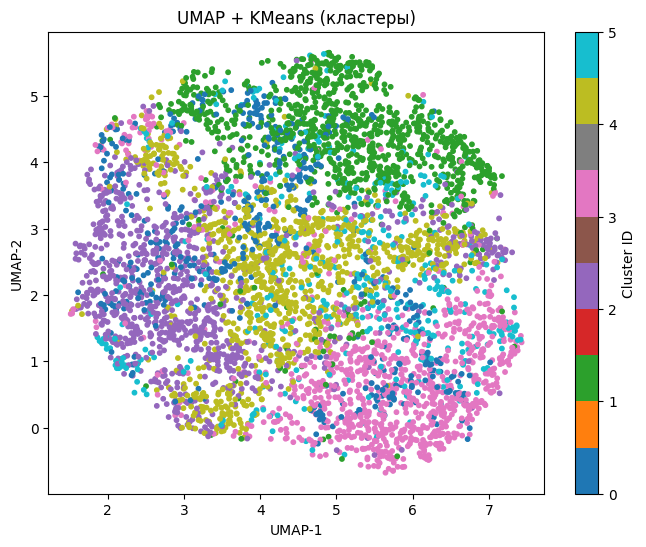

In [37]:

# Сопоставление сущностей с редкостью (только для скинов)
rarity_map = {cs2 + str(row['id']).replace(' ', '_'): row['rarity'] for _, row in df.iterrows() if pd.notna(row['rarity'])}

# Собираем эмбеддинги и метки для сущностей-скинов
X_skin = []
y_skin = []
skin_entities = []
for uri, idx in entity_to_id.items():
    if uri in rarity_map:
        skin_entities.append(uri)
        X_skin.append(entity_embeddings[idx].real)  # извлекаем вещественную часть
        y_skin.append(rarity_map[uri])

X_skin = np.array(X_skin)
print('Эмбеддингов с метками редкости:', X_skin.shape)

# UMAP для снижения размерности
reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(X_skin)

# KMeans (число кластеров = число уникальных значений редкости)
unique_rarities = list(set(y_skin))
n_clusters = len(unique_rarities)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_skin)

# ARI
ari = adjusted_rand_score(y_skin, clusters)
print('Adjusted Rand Index (кластеры vs редкость):', ari)

# Визуализация
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], c=clusters, cmap='tab10', s=10)
plt.title('UMAP + KMeans (кластеры)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar(scatter, label='Cluster ID')
plt.show()




## Классификация редкости скина по эмбеддингам

Используем логистическую регрессию для предсказания редкости на основе эмбеддингов. Выполним стратифицированную кросс-валидацию.


In [38]:

# Преобразуем метки редкости в числовые значения
le = LabelEncoder()
y_encoded = le.fit_transform(y_skin)

# Кросс-валидация
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf = LogisticRegression(max_iter=300)
scores = cross_val_score(clf, X_skin, y_encoded, cv=cv, scoring='accuracy')

print('Accuracy по фолдам:', scores)
print('Средняя accuracy:', scores.mean())


Accuracy по фолдам: [0.95860828 0.94961008 0.94957983]
Средняя accuracy: 0.9525993960871691



## Предсказание недостающих ссылок (link prediction)

Покажем, как предсказать недостающую редкость для скина. Для выбранного скина модель выдает рейтинг возможных значений `hasRarity`.


In [40]:
import torch
import pandas as pd

# Пример скина и истинная редкость
example_uri = skin_entities[0]
true_rarity = rarity_map[example_uri]

print('Пример скина:', example_uri)
print('Истинная редкость:', true_rarity)

# Ищем ID сущности и отношения
h_id = torch.tensor([entity_to_id[example_uri]])
r_id = torch.tensor([result.training.relation_to_id[cs2 + 'hasRarity']])

# Подготавливаем батч троек (h, r, t) со всеми tail-сущностями
all_tail_ids = torch.arange(len(entity_to_id))
hrt = torch.stack([h_id.repeat(len(entity_to_id)), r_id.repeat(len(entity_to_id)), all_tail_ids], dim=1)

# Получаем оценки
scores = result.model.score_hrt(hrt).detach().cpu().numpy().flatten()  # Сделаем одномерным

# Собираем результаты в датафрейм
tail_entities = list(entity_to_id.keys())  # Список всех сущностей
pred_df = pd.DataFrame({
    'tail': tail_entities,
    'score': scores
}).sort_values('score', ascending=False)

# Выводим top-5
print(pred_df.head(5))


Пример скина: http://example.org/cs2#Skin_AK-47_10
Истинная редкость: Classified
                                tail     score
9046                      Classified -3.230485
12336  http://example.org/cs2#Luxury -3.722980
11434                        MilSpec -4.134501
2867                      2023-12-31 -4.181604
722                           -45.93 -4.196163



## Заключение

В этом ноутбуке мы:

1. Загрузили датасет `my_data.csv` с информацией о скинах CS2;
2. Сформировали тройки для графа знаний и объединили их с онтологией;
3. Разделили данные на обучающую и тестовую выборки;
4. Обучили модель векторных представлений RotatE на тройках и оценили её метрики;
5. Извлекли эмбеддинги сущностей и выполнили их кластеризацию, сравнив с истинными метками редкости;
6. Построили простую модель для классификации редкости скинов по эмбеддингам;
7. Показали пример предсказания недостающих связей для отношения `hasRarity`.

Вы можете изменить параметры модели (количество эпох, размер пакетной обработки, тип модели), добавить другие свойства в тройки или использовать свои критерии разбиения train/test.
